# Removing the existing train/validation/test labels by combining the images

In [ ]:
import os
from shutil import copyfile
from google.colab import drive
import numpy as np
from sklearn.model_selection import train_test_split
from shutil import rmtree
from sklearn import metrics

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

os.makedirs('train/NORMAL', exist_ok=True)
os.makedirs('train/PNEUMONIA', exist_ok=True)
os.makedirs('test/NORMAL', exist_ok=True)
os.makedirs('test/PNEUMONIA', exist_ok=True)

# Split NORMAL
train, test = train_test_split(os.listdir('/content/drive/MyDrive/Efficient net b6/dataset/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('/content/drive/MyDrive/Efficient net b6/dataset/NORMAL', img), 
             os.path.join('train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('/content/drive/MyDrive/Efficient net b6/dataset/NORMAL', img), 
             os.path.join('test/NORMAL/', img))

# Split PNEUMONIA
train, test = train_test_split(os.listdir('/content/drive/MyDrive/Efficient net b6/dataset/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)
for img in train:
    copyfile(os.path.join('/content/drive/MyDrive/Efficient net b6/dataset/PNEUMONIA', img), 
             os.path.join('train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('/content/drive/MyDrive/Efficient net b6/dataset/PNEUMONIA', img), 
             os.path.join('test/PNEUMONIA/', img))

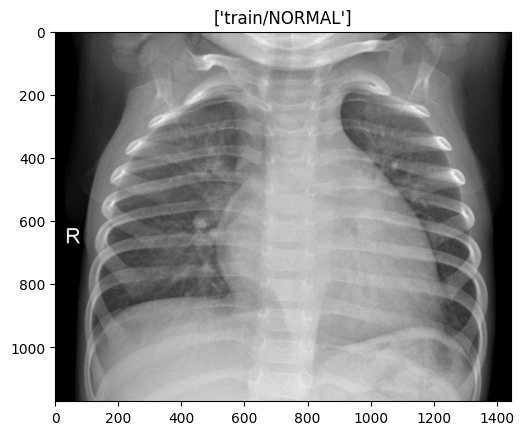

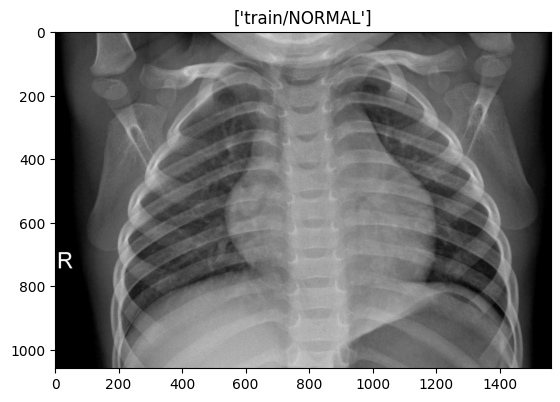

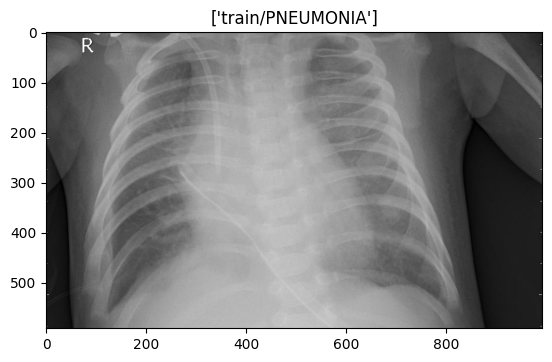

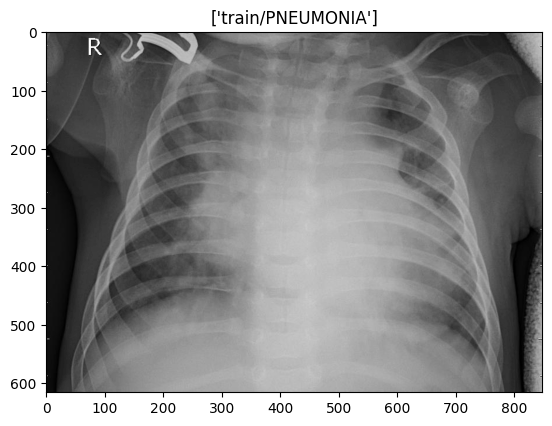

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

for dirname, _, filenames in os.walk('train'):
    for i, file in enumerate(filenames):
        if(i > 1):
            break
        plt.imshow(mpimg.imread(os.path.join(dirname, file)), cmap='gray')
        plt.title(dirname.split('\\'))
        
        plt.show()



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SIZE = 224
BATCH = 32

# image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 3748 images belonging to 2 classes.
Found 936 images belonging to 2 classes.


In [ ]:
# pip install resnet

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

# Callbacks
## Keep the best model
mc = ModelCheckpoint('model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)

# Model
model = tf.keras.applications.ResNet152V2(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2,
    classifier_activation="softmax",
)


## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

model_history = model.fit(train_generator,
                            validation_data=validation_generator,
                            steps_per_epoch=train_generator.n/BATCH,
                            validation_steps=validation_generator.n/BATCH,
                            epochs=20,
                            verbose=1,
                            callbacks=[mc, rlr])

Epoch 1/20
117/117 [==============================] - 218s 840ms/step - loss: 0.3539 - accuracy: 0.8402 - recall_1: 0.8918 - precision_1: 0.8895 - val_loss: 2.0949 - val_accuracy: 0.7297 - val_recall_1: 1.0000 - val_precision_1: 0.7297 - lr: 0.0010
Epoch 2/20
117/117 [==============================] - 81s 692ms/step - loss: 0.2296 - accuracy: 0.9088 - recall_1: 0.9503 - precision_1: 0.9266 - val_loss: 4.4288 - val_accuracy: 0.7297 - val_recall_1: 1.0000 - val_precision_1: 0.7297 - lr: 0.0010
Epoch 3/20
117/117 [==============================] - 93s 791ms/step - loss: 0.2081 - accuracy: 0.9221 - recall_1: 0.9521 - precision_1: 0.9418 - val_loss: 0.7066 - val_accuracy: 0.8088 - val_recall_1: 0.7906 - val_precision_1: 0.9375 - lr: 0.0010
Epoch 4/20
117/117 [==============================] - 92s 785ms/step - loss: 0.1733 - accuracy: 0.9320 - recall_1: 0.9612 - precision_1: 0.9464 - val_loss: 0.4706 - val_accuracy: 0.8237 - val_recall_1: 0.9854 - val_precision_1: 0.8128 - lr: 0.0010
Epoch 5

In [ ]:
# Load the best model
model.load_weights("model.hdf5")

<Figure size 640x480 with 0 Axes>

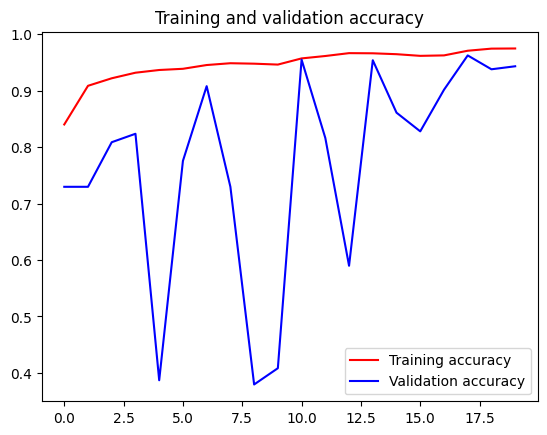

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = model.predict(test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes


Found 1172 images belonging to 2 classes.
37/37 [==============================] - 24s 588ms/step


In [ ]:
# print(preds)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
#pip install mlxtend

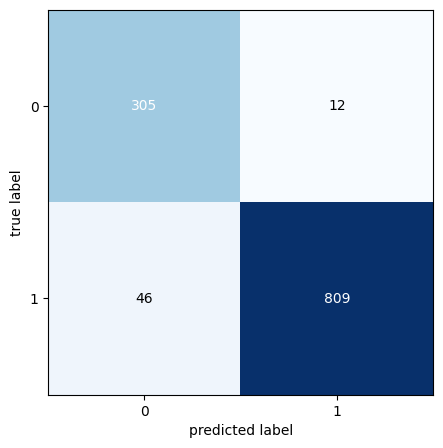

In [ ]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       317
           1       0.99      0.95      0.97       855

    accuracy                           0.95      1172
   macro avg       0.93      0.95      0.94      1172
weighted avg       0.95      0.95      0.95      1172



In [ ]:
from sklearn.metrics import accuracy_score

# Get true labels
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, labels)

# Print accuracy
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 95.05%


In [ ]:
from tensorflow.keras.models import load_model
model_ef = load_model('model.hdf5')

<h2> Testing</h2>

Input image shape: (1, 128, 128, 3)


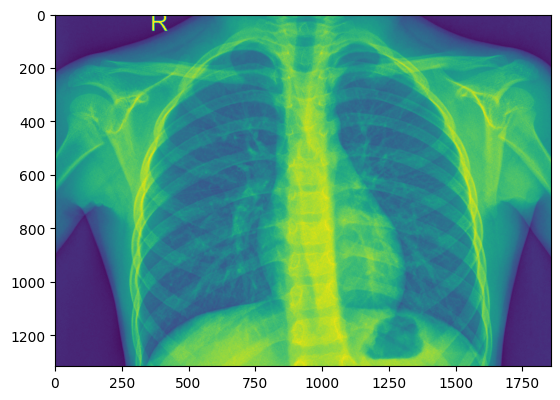

In [ ]:
import cv2
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import numpy as np

img_path = '/content/test/NORMAL/IM-0001-0001.jpeg'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
image_path = "/content/test/NORMAL/IM-0613-0001.jpeg"  # Replace with the actual image path
image = load_img(image_path, target_size=(SIZE, SIZE))
image_array = img_to_array(image) / 255.0  # Rescale pixel values to [0, 1]
image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

# Predict the class
prediction = model_ef.predict(image_array)[0]
print(prediction)

# Interpret the result
threshold = 0.8
if prediction > threshold:
    class_label = "Pneumonia"
else:
    class_label = "Normal"

# Print the predicted class
print("The image is classified as:", class_label)

1/1 [==============================] - 3s 3s/step
[7.879669e-05]
The image is classified as: Normal


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming you have loaded the model as 'loaded_model'

# Perform prediction using the loaded model
pred_probs = model.predict(test_generator)  # Get predicted probabilities
pred_classes = (pred_probs > 0.5).astype(int)  # Convert probabilities to binary classes

# Get true labels
true_labels = test_generator.classes

# Calculate precision, recall, F1 score, and binary accuracy
precision = precision_score(true_labels, pred_classes)
recall = recall_score(true_labels, pred_classes)
f1 = f1_score(true_labels, pred_classes)
accuracy = accuracy_score(true_labels, pred_classes)

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Binary Accuracy:", accuracy)


37/37 [==============================] - 18s 487ms/step
Precision: 0.9865853658536585
Recall: 0.9461988304093567
F1 Score: 0.9659701492537313
Binary Accuracy: 0.9513651877133106


In [ ]:
model.load("model.hdf5")

In [ ]:
# ADDED BY DEBDEEP eta accuracy gulor jnno run korish amr tar o run ache bole dilam
train_acc = round(np.max(model_history.history['accuracy'])*100, 2)
valid_acc = round(np.max(model_history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:   {:.2%}'.format(accuracy))  #, '\033[0m', accuracy,'%\033[0m'

Training Accuracy:  97.49 %
Validation Accuracy:  96.26 %
Test Accuracy:   95.14%


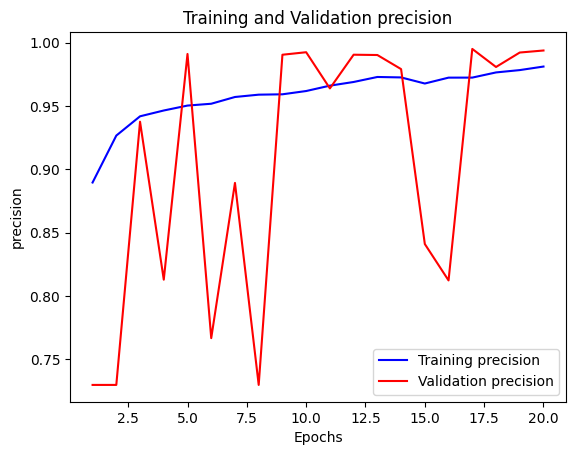

In [ ]:
train_precision = model_history.history['precision_1']
val_precision = model_history.history['val_precision_1']
epochs = range(1, len(train_precision) + 1)
# Plot the Precision vs. epoch graph
plt.plot(epochs, train_precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

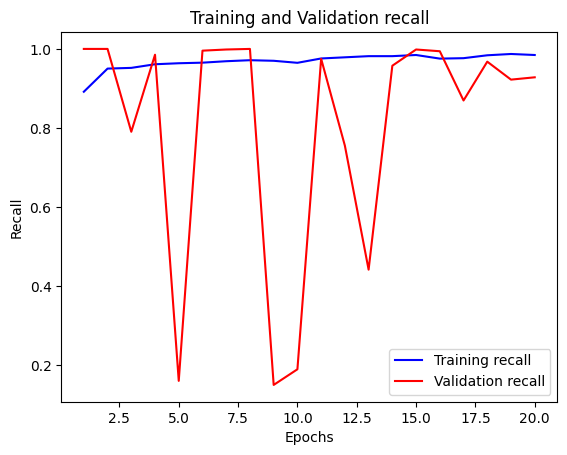

In [ ]:
train_recall = model_history.history['recall_1']
val_recall = model_history.history['val_recall_1']
epochs = range(1, len(train_recall) + 1)
# Plot the Recall vs. epoch graph
plt.plot(epochs, train_recall, 'b', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


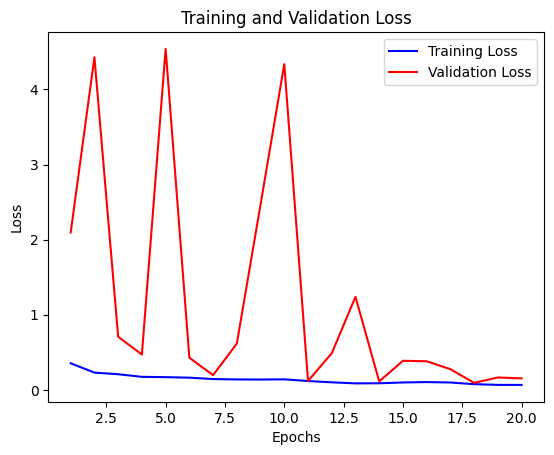

In [ ]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
# Plot the loss vs. epoch graph
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

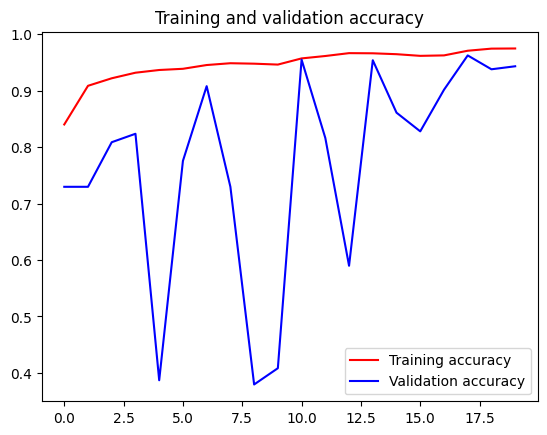

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


37/37 [==============================] - 18s 469ms/step


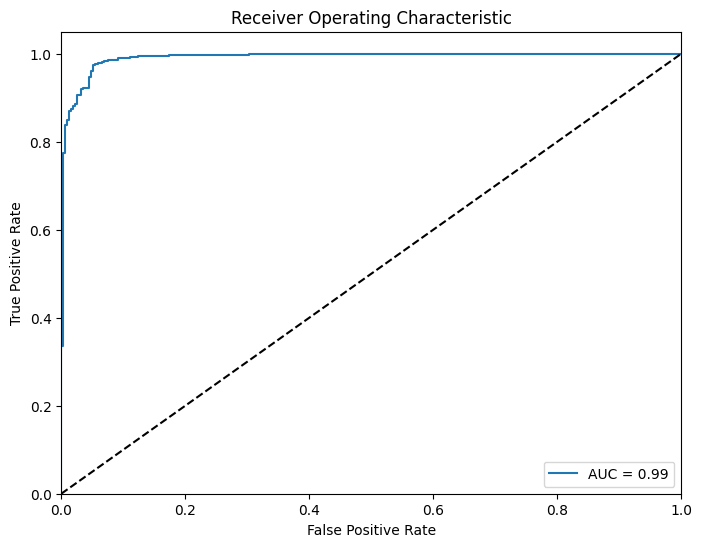

In [ ]:
x_pred = model.predict(test_generator)
fpr, tpr, _ = metrics.roc_curve(test_generator.classes, x_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()